In [ ]:
pip install tensorflow==1.15

In [ ]:
pip install innvestigate

In [100]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import glob
import os
from keras.callbacks import History , ModelCheckpoint
import cv2
from cv2 import imread, createCLAHE 
from keras.optimizers import Adam 
#from glob import globfrom keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, UpSampling1D, RepeatVector,TimeDistributed
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input, GaussianNoise
from keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import  InceptionV3
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import zipfile
from keras import callbacks
from keras import optimizers
from keras import callbacks
from keras.initializers import RandomNormal
from keras.applications import inception_resnet_v2
import innvestigate
import innvestigate.utils as iutils
#from iutils import b
import innvestigate.utils.visualizations as ivis
import numpy as np
from numpy import load
from numpy import save
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime.lime_image import LimeImageExplainer

In [ ]:
#loading the model
model_densenet = load_model('Densenet2-20.hdf5')

In [36]:
#getting unet saved model
unet = load_model('Unet-saved_model.hdf5')

In [132]:
#getting an image from testing  and loading in rgb and gray scale
image = cv2.imread('/Users/vidhi/Desktop/NEW_data/Updated_dataset/test/opacity/Lung_Opacity-795.png')
image_gray = cv2.imread('/Users/vidhi/Desktop/NEW_data/Updated_dataset/test/opacity/Lung_Opacity-795.png',0)

In [61]:
#getting segmented lung using u-net trained model
def lung_segmented (image, rgb_img):
    img = image.reshape(-1,256,256,1)
    output_image = unet.predict(img)
    print(output_image.shape)
    output_image = output_image.reshape(256,256)
    data_seg = 255 * output_image
    mask = data_seg.astype(np.uint8)
    result= cv2.bitwise_and(rgb_img,rgb_img,mask=mask)
    print(result.shape)
    tmp = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(result)
    rgba = [b,g,r,alpha]
    dst = cv2.merge(rgba)
    print(dst.shape)
    return dst

In [63]:
#getting segmented lung of the image and then saving it in directory
segmented_lung = lung_segmented(image_gray, image)
cv2.imwrite('test_img.png', segmented_lung)

(1, 256, 256, 1)
(256, 256, 3)
(256, 256, 4)


True

In [66]:
seg_img= cv2.imread('test_img.png')

In [68]:
#applying XAI on this image
#removing the softmax layer from the loaded model
partial_model = Model(
    inputs=model_densenet.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model_densenet.outputs),
    name=model_densenet.name,
)

In [69]:
def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X
def heatmap(X):
    return ivis.heatmap(X)

In [70]:
#analyzing every image and generating heatmaps and relevances
def XAI(Xai_image, method):
  image = Xai_image.reshape(-1,256,256,3)
  analyzer = innvestigate.create_analyzer(method, partial_model)
  relevance  = analyzer.analyze(image)
  result_processed = postprocess(relevance)
  heat_map = heatmap(result_processed)
  return heat_map[0], relevance[0]

In [73]:
#predicting the output of the segmented image
reshaped_img = seg_img.reshape(-1,256,256,3)
norm_im = reshaped_img/255.
output_score = model_densenet.predict(norm_im)

In [79]:
labels = ['Covid', 'Normal', 'Opacity']
print("Image predicted as",labels[output_score.argmax()])

Image predicted as Opacity


In [82]:
#applying deep taylor to this segmented lung 
heatmap1,rel = XAI(reshaped_img,'deep_taylor')

In [84]:
#applying LRP  to this segmented lung 
heatmap2,re2 = XAI(reshaped_img,'lrp.alpha_1_beta_0_IB')

In [86]:
#applying Guided Backprop  to this segmented lung 
heatmap3,re3 = XAI(reshaped_img,'guided_backprop')

In [88]:
#applying LIME
#reading the image and converting into numpy array
def transform_img_fn(path_list):
    out=[]
    img = image.load_img(path_list, target_size=(256,256,3))
    x = image.img_to_array(img)
    x = x/255.
    x = np.expand_dims(x, axis=0)
    out.append(x)
    return np.vstack(out)

In [103]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
lime_img = transform_img_fn('/Users/vidhi/Desktop/NEW_data/Updated_dataset/test/opacity/Lung_Opacity-795.png')

In [ ]:
from skimage.segmentation import mark_boundaries
explainer = LimeImageExplainer()
exp = explainer.explain_instance(lime_img[0], model_densenet.predict, top_labels=5, hide_color=0, num_samples=100)
temp, mask = exp.get_image_and_mask(exp.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=True)

In [107]:
top_feature = mark_boundaries(temp / 2 + 0.5, mask)

In [138]:
Image = cv2.imread('/Users/vidhi/Desktop/NEW_data/Updated_dataset/test/opacity/Lung_Opacity-795.png')

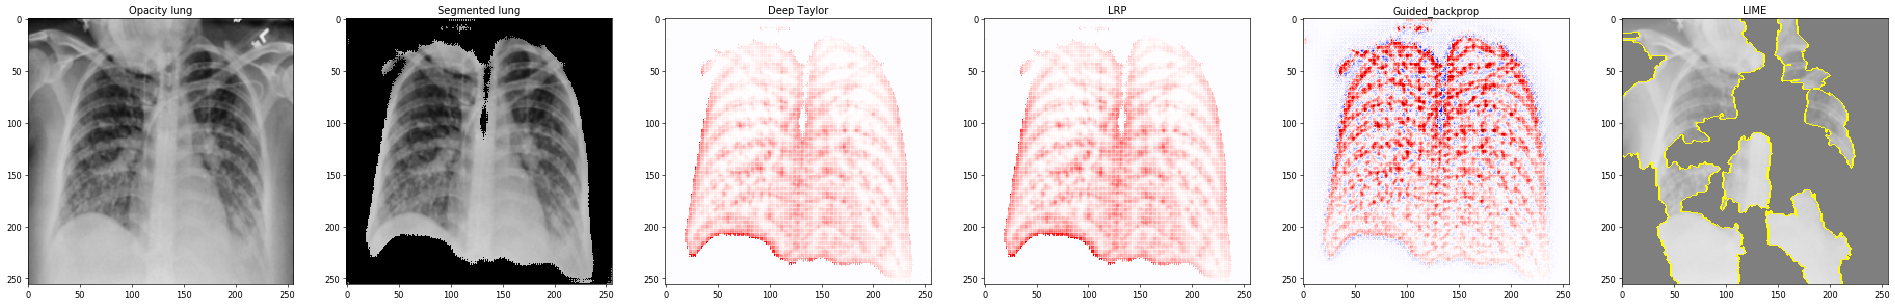

In [143]:
fig = plt.figure(figsize=(40, 40), dpi = 60)
axs = fig.subplots(1, 6)
axs[0].set_title('Opacity lung')
axs[0].imshow(Image)
axs[1].set_title('Segmented lung')
axs[1].imshow(seg_img)
axs[2].set_title('Deep Taylor')
axs[2].imshow(heatmap1)
axs[3].set_title('LRP')
axs[3].imshow(heatmap2)
axs[4].set_title('Guided_backprop')
axs[4].imshow(heatmap3)
axs[5].set_title('LIME')
axs[5].imshow(top_feature)